## Distance formulas

### Jaccard Coefficient/Distance

$J(A,B) = \dfrac{|A \cap B|}{|A \cup B}$

Jaccard similarity coefficient: intersection of A and B divided by the union of A and B
- union: all unique possible values from each set combined
- intersection: what they have in common

Jaccard distance: 1 - similarity coefficient

Best for binary and categorical data

### Minkowski Distance

**Manhattan/Taxi**

grid system

$distance = \sum{|n_1 - n_2|}$


**Euclidean/Helicopter**

straight line

$distance = \sum{\sqrt{(n_1 - n_2)^2}}$


**What to use?**

- Both are *Minkowski distances*
- varies by orders of *p* 
    - Manhattan has a p of 1 = straight lines
    - Euclidean has a p of 2 = curved, continuous

In [3]:
import pandas as pd
from sklearn import cross_validation
df = pd.read_csv("../../DAT18NYC/data/credit-data-post-import.csv")

train, test = cross_validation.train_test_split(df)
train = pd.DataFrame(train, columns=df.columns)
test = pd.DataFrame(test, columns=df.columns)

In [4]:
from sklearn.neighbors import KNeighborsRegressor

income_imputer = KNeighborsRegressor(n_neighbors=1)

# split our data into 2 groups; data containing nulls, and data not containing nulls.
# we'll train on the latter and make 'predictions' on the null data to impute monthly_income
train_w_monthly_income = train[train.monthly_income.isnull()==False]
train_w_null_monthly_income = train[train.monthly_income.isnull()==True]

In [5]:
correlations = train_w_monthly_income.corr()

# which columns are most correlated with monthly income?
# This will be one quick way to help us find our KNN features

monthly_income_correlations = pd.Series(correlations.ix[:, 5])
monthly_income_correlations.order(ascending=False)

monthly_income                                 1.000000
number_real_estate_loans_or_lines              0.116509
number_of_open_credit_lines_and_loans          0.082508
number_of_dependents                           0.058533
age                                            0.034942
revolving_utilization_of_unsecured_lines       0.007451
number_of_time30-59_days_past_due_not_worse   -0.009962
number_of_time60-89_days_past_due_not_worse   -0.010493
number_of_times90_days_late                   -0.012022
serious_dlqin2yrs                             -0.017931
debt_ratio                                    -0.025034
Name: monthly_income, dtype: float64

In [6]:
cols = ['number_real_estate_loans_or_lines', 'number_of_open_credit_lines_and_loans']

income_imputer = KNeighborsRegressor(n_neighbors=1, p=2)
income_imputer.fit(train_w_monthly_income[cols], train_w_monthly_income.monthly_income)

# fill in the missing data with the imputed values!
train_w_null_monthly_income['monthly_income'] = income_imputer.predict(train_w_null_monthly_income[cols])

test['monthly_income_imputed'] = income_imputer.predict(test[cols])
test[['monthly_income', 'monthly_income_imputed']].head()

c:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,monthly_income,monthly_income_imputed
0,NaN,4166
1,11000,4200
2,7100,10196
3,2000,4000
4,11100,5047


In [7]:
income_imputer = KNeighborsRegressor(n_neighbors=2, p=2)
income_imputer.fit(train_w_monthly_income[cols], train_w_monthly_income.monthly_income)

# fill in the missing data with the imputed values!
train_w_null_monthly_income['monthly_income'] = income_imputer.predict(train_w_null_monthly_income[cols])

test['monthly_income_imputed'] = income_imputer.predict(test[cols])
test[['monthly_income', 'monthly_income_imputed']].head()

c:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,monthly_income,monthly_income_imputed
0,NaN,4883
1,11000,4200
2,7100,9398
3,2000,5000
4,11100,8640


In [8]:
from sklearn import grid_search

imputer = KNeighborsRegressor()
parameters1 = {'p': (1, 2), 'n_neighbors': range(1, 23, 3)}

regr = grid_search.GridSearchCV(imputer, parameters1, scoring='mean_squared_error')
regr.fit(train_w_monthly_income[cols], train_w_monthly_income.monthly_income)

GridSearchCV(cv=None,
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'p': (1, 2), 'n_neighbors': [1, 4, 7, 10, 13, 16, 19, 22]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_squared_error', verbose=0)

In [9]:
parameters2 = {'metric': ['jaccard'], 'n_neighbors': range(1, 23, 3)}
jac = grid_search.GridSearchCV(imputer, parameters2, scoring='mean_squared_error')
jac.fit(train_w_monthly_income[cols], train_w_monthly_income.monthly_income)

GridSearchCV(cv=None,
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_neighbors': [1, 4, 7, 10, 13, 16, 19, 22], 'metric': ['jaccard']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_squared_error', verbose=0)

In [10]:
print "----------Minkowski Grid Search-------------"
for score in regr.grid_scores_:
    print score

print regr.best_estimator_ 

print "----------Jaccard Grid Search-------------"
for score in jac.grid_scores_:
    print score

print jac.best_estimator_ 

----------Minkowski Grid Search-------------
mean: -264729387.04902, std: 122937290.18552, params: {'n_neighbors': 1, 'p': 1}
mean: -264732001.70314, std: 122946086.45259, params: {'n_neighbors': 1, 'p': 2}
mean: -248797718.94877, std: 132666456.20075, params: {'n_neighbors': 4, 'p': 1}
mean: -248773170.40092, std: 132676196.09074, params: {'n_neighbors': 4, 'p': 2}
mean: -245118815.63078, std: 131264199.99809, params: {'n_neighbors': 7, 'p': 1}
mean: -245079331.05169, std: 131310259.60077, params: {'n_neighbors': 7, 'p': 2}
mean: -243731275.99629, std: 131176803.58273, params: {'n_neighbors': 10, 'p': 1}
mean: -243753188.96959, std: 131167590.90826, params: {'n_neighbors': 10, 'p': 2}
mean: -243026351.43935, std: 131142964.89528, params: {'n_neighbors': 13, 'p': 1}
mean: -243003506.28133, std: 131150287.46569, params: {'n_neighbors': 13, 'p': 2}
mean: -242460717.83137, std: 131012275.74755, params: {'n_neighbors': 16, 'p': 1}
mean: -242335436.57873, std: 130947760.56800, params: {'n_n

In [11]:
from sklearn import grid_search, datasets
from sklearn.neighbors import KNeighborsClassifier
iris = datasets.load_iris()
parameters = {'p':[2], 'n_neighbors':range(1, 100)}
knn = KNeighborsClassifier()
clf = grid_search.GridSearchCV(knn, parameters, scoring='accuracy')
clf.fit(iris.data, iris.target)                            

GridSearchCV(cv=None,
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'p': [2], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)

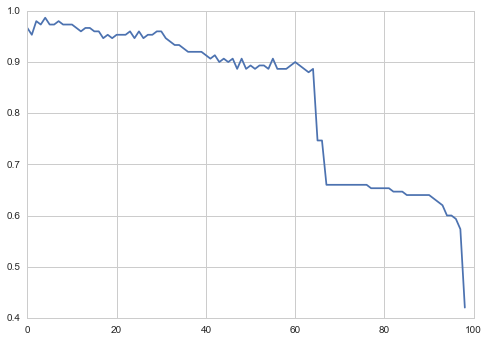

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
scores = [i.mean_validation_score for i in clf.grid_scores_]
plt.plot(scores)

# Unsupervised Learning

What do we do when we don't know y?

Primary unsupervised learning principles:
- **Dimensionality Reduction**: A technique to reducing the number of features that exist , most often maintaining the variance of the data.
- **Clustering**: A technique of creating new structure, often using distance or similarity as a guideline.

Keep in mind the similarities here; clustering is unsupervised, classification is supervised (we already know the answer)


**When do we use clustering?**

We need to divide our data into groups. We believe there is some "hidden" statistic in our data that could be defined by clusters:
- **text clustering**: Using additional distance techniques like tf−idf (term frequency-inverse document frequency) and cosine similarity to identify clusters of text and topics
- **consumer marketing and targeting**: Identifying clusters of consumers based purchase history data is an effective strategy on ad placement
- **genetics**: Gene expressing is typically done with a clustering technique, determining genes that respond similarly across experiments
- **recommendation**: Everytime you queue up Netflix and you see a playlist called "Movies Bill Murray would watch at 9:00pm," this is an application of clustering.

In [2]:
import pandas as pd
beers = pd.read_csv('../../DAT18NYC/data/beer.txt', sep=' ')

beers

,Beer,Calories,Sodium,Alcohol,Cost
0,Budweiser,144,15,4.7,0.43
1,Schlitz,151,19,4.9,0.43
2,Lowenbrau,157,15,0.9,0.48
3,Kronenbourg,170,7,5.2,0.73
4,Heineken,152,11,5.0,0.77
5,Old_Milwaukee,145,23,4.6,0.28
6,Augsberger,175,24,5.5,0.40
7,Srohs_Bohemian_Style,149,27,4.7,0.42
8,Miller_Lite,99,10,4.3,0.43
9,Budweiser_Light,113,8,3.7,0.40


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C215DD8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000D36D748>]], dtype=object)

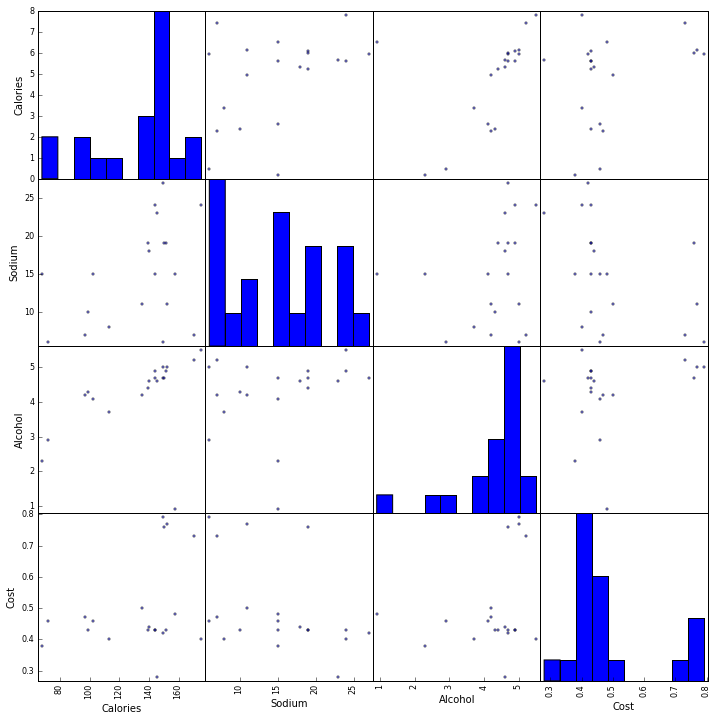

In [3]:
% matplotlib inline

pd.scatter_matrix(beers, figsize=(12,12))

## K Means

Solves for *k* number of clusters

1. Picks k random points in the dimensional space (**centroids**)
2. Calculates distance of all observations to centroids and assign it to the nearest one
3. Discards the centroids, takes the mean distance of each cluster and makes it the newest centroid
4. Repeat until convergence is reached, centroid movement is within a defined boundary

**How do we define k?**
- should never be more than 1/2 of observations

Populating the interactive namespace from numpy and matplotlib


(1, 75)

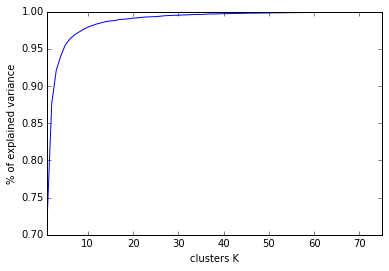

In [8]:
% pylab inline
from sklearn import cluster, datasets
from __future__ import division

iris = datasets.load_iris()

sepal_data = iris.data[:, :2]
krange = range(1, int(sepal_data.shape[0] / 2))
sum_squares = [cluster.KMeans(n_clusters=k).fit(sepal_data).inertia_ for k in krange]

variance_explained = [1.0 - (s / sum(sum_squares)) for s in sum_squares]
plt.figure()
plt.plot(range(1, 75), variance_explained)
plt.ylabel('% of explained variance')
plt.xlabel('clusters K')
plt.xlim([1, 75])

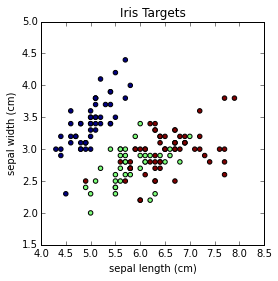

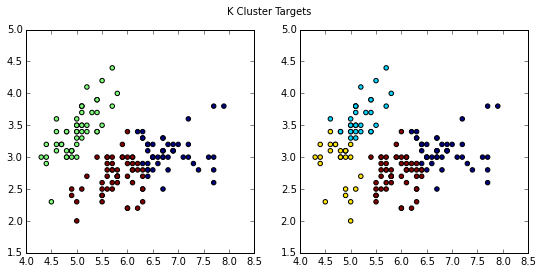

In [9]:
## -- Actual --
plt.figure(figsize=[4, 4])
plt.scatter(sepal_data[:, 0], sepal_data[:, 1], c=iris.target)
plt.title('Iris Targets')
plt.ylabel(iris.feature_names[1])
plt.xlabel(iris.feature_names[0])

## -- 3 Clusters --
clusters_3 = cluster.KMeans(n_clusters=3).fit(sepal_data)
fig, ax = plt.subplots(1, 2, figsize=[9, 4])
fig.suptitle('K Cluster Targets')
ax[0].scatter(sepal_data[:, 0], sepal_data[:, 1], c=clusters_3.predict(sepal_data))

## -- 4 Clusters --
clusters_4 = cluster.KMeans(n_clusters=4).fit(sepal_data)
ax[1].scatter(sepal_data[:, 0], sepal_data[:, 1], c=clusters_4.predict(sepal_data))


In [4]:
from sklearn import tree

# fit a classification tree with max_depth=2 on all data
treeclf = tree.DecisionTreeClassifier(max_depth=2, random_state=1)
treeclf.fit(sepal_data, clusters_3.predict(sepal_data))

# create a Graphviz file
with open("iris_clusters.dot", 'wb') as f:
    f = tree.export_graphviz(treeclf, out_file=f, feature_names=iris.feature_names[:3])

NameError: name 'sepal_data' is not defined

In [5]:
beers

,Beer,Calories,Sodium,Alcohol,Cost
0,Budweiser,144,15,4.7,0.43
1,Schlitz,151,19,4.9,0.43
2,Lowenbrau,157,15,0.9,0.48
3,Kronenbourg,170,7,5.2,0.73
4,Heineken,152,11,5.0,0.77
5,Old_Milwaukee,145,23,4.6,0.28
6,Augsberger,175,24,5.5,0.40
7,Srohs_Bohemian_Style,149,27,4.7,0.42
8,Miller_Lite,99,10,4.3,0.43
9,Budweiser_Light,113,8,3.7,0.40


In [25]:
#features = list(beers.columns)
#features.remove('Beer')
feature1 = 'Alcohol'
feature2 = 'Cost'
features = list([feature1, feature2])

Populating the interactive namespace from numpy and matplotlib


(1, 10)

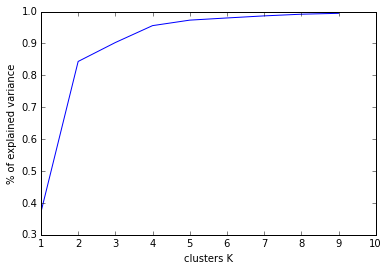

In [26]:
% pylab inline
from sklearn import cluster, datasets
from __future__ import division

rangemax = int(beers.shape[0] / 2)

krange = range(1, rangemax)

sum_squares = [cluster.KMeans(n_clusters=k).fit(beers[features]).inertia_ for k in krange]

variance_explained = [1.0 - (s / sum(sum_squares)) for s in sum_squares]
plt.figure()
plt.plot(range(1, rangemax), variance_explained)
plt.ylabel('% of explained variance')
plt.xlabel('clusters K')
plt.xlim([1, rangemax])

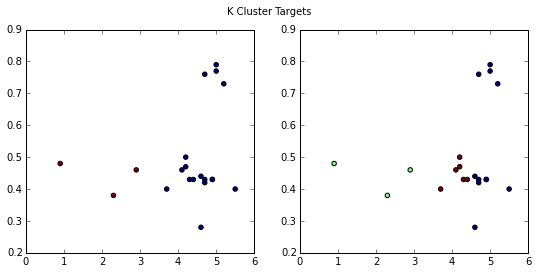

In [29]:
## -- 2 Clusters --
clusters_2 = cluster.KMeans(n_clusters=2).fit(beers[features])
fig, ax = plt.subplots(1, 2, figsize=[9, 4])
fig.suptitle('K Cluster Targets')
ax[0].scatter(beers[feature1], beers[feature2], c=clusters_2.predict(beers[features]))

## -- 3 Clusters --
clusters_3 = cluster.KMeans(n_clusters=3).fit(beers[features])
ax[1].scatter(beers[feature1], beers[feature2], c=clusters_3.predict(beers[features]))


In [12]:
from sklearn import tree

# fit a classification tree with max_depth=2 on all data
treeclf = tree.DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(beers[features], clusters_2.predict(beers[features]))

# create a Graphviz file
with open("beer_clusters.dot", 'wb') as f:
    f = tree.export_graphviz(treeclf, out_file=f, feature_names=features)

In [47]:
import bs4
import requests

url = 'https://www.google.com/search?q=data+science&start=%s'
all_descr = []

for p in range(0, 5):
    search_url = url % str(p)
    print search_url
    l = requests.get(search_url)
    soup = bs4.BeautifulSoup(l.text)    
    print soup
    spans = soup.findAll('span', { "class" : "st" })    
    descr = [span.text.encode('ascii', 'replace') for span in spans]
    print descr
    all_descr.append(descr)

print len(all_descr)
descriptions = pd.DataFrame(all_descr)

descriptions

https://www.google.com/search?q=data+science&start=0
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">
<html>
<head><meta content="text/html; charset=utf-8" http-equiv="content-type"/><meta content="initial-scale=1" name="viewport"/><title>https://www.google.com/search?q=data+science&amp;start=0</title></head>
<body onload="e=document.getElementById('captcha');if(e){e.focus();}" style="font-family: arial, sans-serif; background-color: #fff; color: #000; padding:20px; font-size:18px;">
<div style="max-width:400px;">
<hr noshade="" size="1" style="color:#ccc; background-color:#ccc;"/><br/>
 
  To continue, please type the characters below:<br/><br/>
<img alt="Please enable images" border="1" src="/sorry/image?id=1398979569541814653&amp;hl=en"/><br/><br/><form action="CaptchaRedirect" method="get"><input name="continue" type="hidden" value="https://www.google.com/search?q=data+science&amp;start=0"/><input name="id" type="hidden" value="1398979569541814653"/><input id="captch

""
0
1
2
3
4
